# Business Problem

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. It also features singing cats. We're not kidding!

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention.

<center><iframe width="560" height="315" src="https://www.datacamp.com/projects/184" frameborder="0" allow="accelerometer; autoplay; clipboard-write; encrypted-media; gyroscope; picture-in-picture" allowfullscreen></iframe></iframe></center>


### Data Description from (https://www.datacamp.com/projects/184)

<p>The data is from 90,189 players that installed the game while the AB-test was running. The variables are:</p>
<ul>
<li><code>userid</code> - a unique number that identifies each player.</li>
<li><code>version</code> - whether the player was put in the control group (<code>gate_30</code> - a gate at level 30) or the test group (<code>gate_40</code> - a gate at level 40).</li>
<li><code>sum_gamerounds</code> - the number of game rounds played by the player during the first week after installation
<li><code>retention_1</code> - did the player come back and play 1 day after installing?</li>
<li><code>retention_7</code> - did the player come back and play 7 days after installing?</li>
</ul>
<p>When a player installed the game, he or she was randomly assigned to either <code>gate_30</code> or <code>gate_40</code>. </p>

# 0.0 Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency

## 0.1 Load Data

In [2]:
path = 'C:/Users/edils/repos/teste_ab/data/'

df_raw = pd.read_csv(path + 'cookie_cats.csv')

In [3]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


# 1.0 Data Understanding

In [73]:
df1 = df_raw.copy()

In [74]:
df1.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


## 1.1 Check Homogeinity

In [75]:
df1.groupby('version').agg({
        'version':['count'],
        'sum_gamerounds':['min','max','mean','std'],
        'retention_1':['count'],
        'retention_7':['count']
    
}).reset_index()


version        sum_gamerounds                               retention_1  \
            count            min    max       mean         std       count   
0  gate_30  44700              0  49854  52.456264  256.716423       44700   
1  gate_40  45489              0   2640  51.298776  103.294416       45489   

  retention_7  
        count  
0       44700  
1       45489

There is a strange value on sum_gamerounds max value, I will investigate with a boxplot.

## 1.2 Check Outliers

<Axes: >

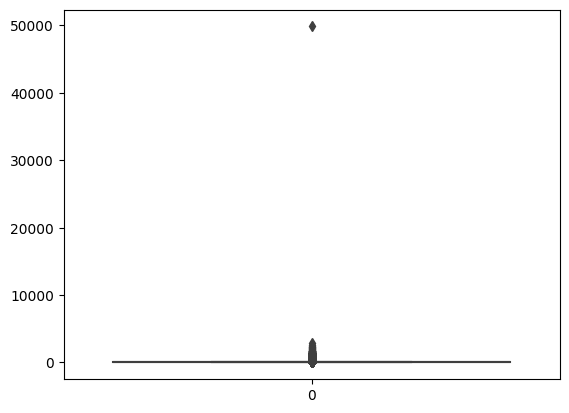

In [76]:
sns.boxplot(df1['sum_gamerounds'])

We have an outlier with sum_gamerounds = 49854. Let's remove it.

In [77]:
df1 = df1.loc[df1['sum_gamerounds'] != 49854,:]

## 1.3 Check Na / Zeros

     sum_gamerounds  percentage
0                 1    0.061405
1                 2    0.051071
2                 0    0.044285
3                 3    0.043886
4                 4    0.040238
..              ...         ...
936             933    0.000011
937             617    0.000011
938            1462    0.000011
939             578    0.000011
940             708    0.000011

[941 rows x 2 columns]


<Axes: xlabel='sum_gamerounds', ylabel='Count'>

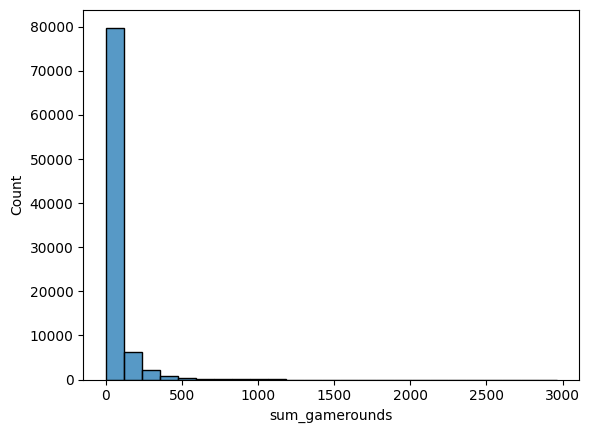

In [78]:
# Criar uma tabela de frequência para sum_gamerounds
game_rounds = df1['sum_gamerounds'].value_counts(normalize=True).reset_index()
game_rounds.columns = ['sum_gamerounds', 'percentage']

# Exibir a distribuição de porcentagem de sum_gamerounds
print(game_rounds)

sns.histplot(df1['sum_gamerounds'], bins=25)

About 4% of my customers did not play the game (0 Game Rounds). Let's remove them.

We also know that most of customers played only a few rounds

In [79]:
df1 = df1.loc[df1['sum_gamerounds'] != 0,:]

In [80]:
df1.isna().sum()

userid            0
version           0
sum_gamerounds    0
retention_1       0
retention_7       0
dtype: int64

## 1.4 Retention Proportion

C:\Users\edils\AppData\Local\Temp\ipykernel_4992\3858841341.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  less_50['retention_1'] = less_50['retention_1'].apply(lambda x: 1 if x == True else 0)
C:\Users\edils\AppData\Local\Temp\ipykernel_4992\3858841341.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  less_50['retention_7'] = less_50['retention_7'].apply(lambda x: 1 if x == True else 0)
C:\Users\edils\AppData\Local\Temp\ipykernel_4992\3858841341.py:20: SettingWithCopyWarning: 
A value is trying to 

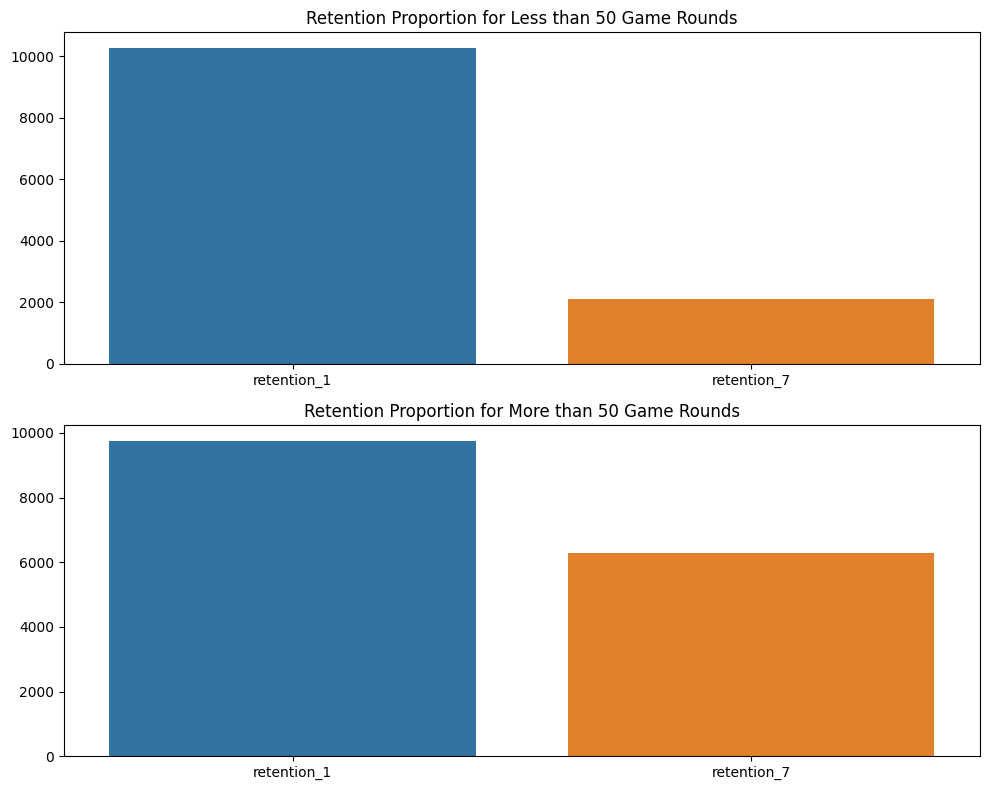

In [81]:
#Lets analyze retention for < 50 game rounds and >50 game rounds

#transform false/true in 0 and 1

fig, axes = plt.subplots(2,1, figsize=(10,8))

less_50 = df1.loc[df1['sum_gamerounds'] <= 50, :]

less_50['retention_1'] = less_50['retention_1'].apply(lambda x: 1 if x == True else 0)
less_50['retention_7'] = less_50['retention_7'].apply(lambda x: 1 if x == True else 0)


retention_proportion_50 = less_50[['version', 'retention_1','retention_7']].groupby('version').sum().reset_index()

sns.barplot(retention_proportion_50, ax=axes[0], errorbar=None)
axes[0].set_title('Retention Proportion for Less than 50 Game Rounds')

more_50 = df1.loc[df1['sum_gamerounds'] > 50, :]

more_50['retention_1'] = more_50['retention_1'].apply(lambda x: 1 if x == True else 0)
more_50['retention_7'] = more_50['retention_7'].apply(lambda x: 1 if x == True else 0)


retention_proportion_more_50 = more_50[['version', 'retention_1','retention_7']].groupby('version').sum()

sns.barplot(retention_proportion_more_50, ax=axes[1], errorbar=None)
axes[1].set_title('Retention Proportion for More than 50 Game Rounds')

plt.tight_layout()
fig.show()

We can see that retention is higher for 7 days as players starts playing more than the average 50 Game Rounds.

## Retention Rate for Each Group

In [82]:
df_rate = df1.copy()

In [83]:
df_rate['retention_1'] = df1['retention_1'].apply(lambda x: 1 if x == True else 0)
df_rate['retention_7'] = df1['retention_7'].apply(lambda x: 1 if x == True else 0)

In [85]:
df_rate[['version', 'retention_1','retention_7']].groupby('version').sum().reset_index()

total_gate_30 = len(df_rate.loc[df_rate['version'] == 'gate_30',:])
total_gate_40 = len(df_rate.loc[df_rate['version'] == 'gate_40',:])
total_players = len(df_rate)

gate_30_ret_1 = df_rate.loc[df_rate['version'] == 'gate_30','retention_1'].sum()
gate_40_ret_1 = df_rate.loc[df_rate['version'] == 'gate_40','retention_1'].sum()
gate_30_ret_7 = df_rate.loc[df_rate['version'] == 'gate_30','retention_7'].sum()
gate_40_ret_7 = df_rate.loc[df_rate['version'] == 'gate_40','retention_7'].sum()

print(f'Retention Rate After 1 day Installing for Gate 30: {gate_30_ret_1/total_players:.3f}')
print(f'Retention Rate After 1 day Installing for Gate 40: {gate_40_ret_1/total_players:.3f}')
print(f'Retention Rate After 7 days Installing for Gate 30: {gate_30_ret_7/total_players:.3f}')
print(f'Retention Rate After 7 days Installing for Gate 40: {gate_40_ret_7/total_players:.3f}')

Retention Rate After 1 day Installing for Gate 30: 0.232
Retention Rate After 1 day Installing for Gate 40: 0.233
Retention Rate After 7 day Installing for Gate 30: 0.098
Retention Rate After 7 day Installing for Gate 40: 0.096


## 1.5 Check for Bad Users(both Group and Control at the same time)

In [68]:
# Check if There's same user for both group and treatment
df1[['version','userid']].groupby('userid').nunique().query('version > 1').reset_index()

,userid,version


# 2.0 Experiment Design

--- 

# Objective

Analyze customer retention by moving the gate to level 30 to level 40.

 - Gate 30 = Control Group
 - Gate 40 = Treatment Group

 - H0: Moving the gate does not make a difference in retention
 - H1: Moving the gate makes a difference in retention
 
 - Significance Level: 0.05

## 2.1 Sample Size

In [69]:
pd.crosstab(df1['version'], df1['retention_1'])

retention_1,False,True
version,,
gate_30,24665,20034
gate_40,25370,20119


## 2.2 Chi-Squared Test

### 2.2.1 Test for 1 Day Retention

In [70]:
# Create contingency table for retention_1
contingency_table_1 = pd.crosstab(df1['version'], df1['retention_1'])

# Chi-squared test for retention_1
chi2_stat_1, p_value_1, dof_1, expected_1 = chi2_contingency(contingency_table_1)

# Results for retention_1
print("Retention 1-day:")
print(f"Chi-squared Statistic: {chi2_stat_1}")
print(f"P-value: {p_value_1}")
print(f"Degrees of Freedom: {dof_1}")
print("Contingency Table:")
print(contingency_table_1)
print("Expected Frequencies:")
print(expected_1)

Retention 1-day:
Chi-squared Statistic: 3.169835543170799
P-value: 0.07500999897705692
Degrees of Freedom: 1
Contingency Table:
retention_1  False  True 
version                  
gate_30      24665  20034
gate_40      25370  20119
Expected Frequencies:
[[24798.35970417 19900.64029583]
 [25236.64029583 20252.35970417]]


---

# Retention After 1 day playing:

### P-value: 0.075 (greater than 0.05)

Conclusion: There is **not sufficient statistical** evidence to reject the null hypothesis. This suggests that, based on the observed data, there is no significant association between the game version (gate_30 or gate_40) and player retention after 1 day. This might happens because the player had no time to get to gate 30/40 in the first day playing.

---

### 2.2.2 Test for 7 days Retention

In [71]:
contingency_table_7 = pd.crosstab(df1['version'], df1['retention_7'])


chi2_stat_7, p_value_7, dof_7, expected_7 = chi2_contingency(contingency_table_7)

# Results for retention_7
print("Retention 7-day:")
print(f"Chi-squared Statistic: {chi2_stat_7}")
print(f"P-value: {p_value_7}")
print(f"Degrees of Freedom: {dof_7}")
print("Contingency Table:")
print(contingency_table_7)
print("Expected Frequencies:")
print(expected_7)

Retention 7-day:
Chi-squared Statistic: 9.91527552890567
P-value: 0.0016391259678654425
Degrees of Freedom: 1
Contingency Table:
retention_7  False  True 
version                  
gate_30      36198   8501
gate_40      37210   8279
Expected Frequencies:
[[36382.49203885  8316.50796115]
 [37025.50796115  8463.49203885]]


---

# Retention After 7 days playing:

### P-Value: P-value: 0.0016 (less than 0.05) 

Conclusion: Based on the observed data, **there is statistical evidence to reject the null hypothesis.** This suggests that a **significant association exists** between the game version and player retention after 7 days.

---

# 3.0 Business Performance

In [88]:
# Retention rates from your results
retention_rate_1_day_gate_30 = 0.232
retention_rate_1_day_gate_40 = 0.233
retention_rate_7_days_gate_30 = 0.098
retention_rate_7_days_gate_40 = 0.096

# Initial number of players
initial_players = len(df1)

# Estimated LTV 
estimated_ltv = 100 

# Calculate projected retained players after 7 days for both groups
projected_retained_players_gate_30 = initial_players * retention_rate_7_days_gate_30
projected_retained_players_gate_40 = initial_players * retention_rate_7_days_gate_40

# Calculate additional revenue
additional_revenue_gate_30 = projected_retained_players_gate_30 * estimated_ltv
additional_revenue_gate_40 = projected_retained_players_gate_40 * estimated_ltv

# Calculate the potential increase in revenue
potential_increase_in_revenue = additional_revenue_gate_40 - additional_revenue_gate_30

print(f"Projected Retained Players (gate_30): {projected_retained_players_gate_30:.0f}")
print(f"Projected Retained Players (gate_40): {projected_retained_players_gate_40:.0f}")
print(f"Additional Revenue (gate_30): ${additional_revenue_gate_30:.2f}")
print(f"Additional Revenue (gate_40): ${additional_revenue_gate_40:.2f}")
print(f"Potential Increase in Revenue: ${potential_increase_in_revenue:.2f}")

Projected Retained Players (gate_30): 8447
Projected Retained Players (gate_40): 8275
Additional Revenue (gate_30): $844701.20
Additional Revenue (gate_40): $827462.40
Potential Increase in Revenue: $-17238.80


--- 

# Conclusion

We have a difference in moving the gate to level 30 to 40, but it actually decreases the potential revenue, because the players retention is lower after 7 days.

It's appropriate to conclude that, according to the data and analysis performed, the change in gate placement has **not yielded a positive impact on player retention and potential revenue**.

Considering the LTV of each player of 100$, the company will lose $17238.80 in the long run.